In [36]:
import numpy as np
import torch
import scipy.sparse as sp
import matplotlib.pyplot as plt
import nibabel as nib
from dipy.segment.mask import median_otsu

import importlib
from pathlib import Path

import sys

sys.path.append(str(Path.home() / "Projects" / "MaxEnt" / "Code" / "numpy"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr
import D2_admm_solver as das

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)
importlib.reload(das)

<module 'D2_admm_solver' from '/Users/xunan/Projects/MaxEnt/Code/numpy/D2_admm_solver.py'>

In [12]:
mask  = nib.load("~/Projects/MaxEnt/Data/MultiTE_dMRI/brain_mask.nii.gz")
mask = np.flip(mask.get_fdata(), axis = 0).astype(bool) # always flip it along axis 0 such that the plots match the views in MRView

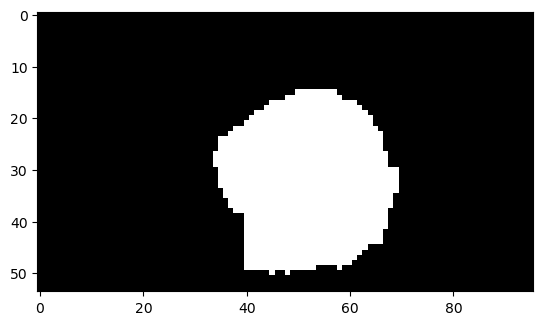

In [14]:
plt.imshow(np.fliplr(np.flipud(mask[23, :, :].T)), cmap='gray')
plt.show()

In [ ]:

folder_list = ['TE71ms', 'TE101ms', 'TE131ms', 'TE161ms', 'TE191ms']

Sqs   = np.zeros((96, 96, 54, 5, 5))
Sb0   = np.zeros((96, 96, 54, 5))
sigma = np.zeros((96, 96, 54, 5, 5))

for m, folder in enumerate(folder_list):
    
    path_bval = f"/Users/xunan/Projects/MaxEnt/Data/MultiTE_dMRI/{folder}/Processed/dwi_bval.txt"
    path_nii  = f"/Users/xunan/Projects/MaxEnt/Data/MultiTE_dMRI/{folder}/Processed/dwi_eddy_unring.nii"

    img  = nib.load(path_nii)
    signal = np.flip(img.get_fdata(), axis = 0)

    bvals = np.loadtxt(path_bval) / 1000 # in unit ms/{\mu m} ^2

    Sb0[..., m] = np.mean(signal[:,:,:,bvals==0], axis=3)

    signal_normed = signal / np.repeat(Sb0[..., m:m+1], len(bvals), axis = -1)

    for i, b in enumerate(np.unique(bvals[bvals!=0])):
        Sqs[..., m, i] =  np.mean(signal_normed[..., bvals == b], axis = -1)
        sigma[..., m, i] = np.std(signal_normed[..., bvals == 0], axis = -1)
    print(np.std(signal_normed[..., bvals == 0]))


In [39]:
mask, lin2idx = bf.mask_brain(Sb0, median_radius = 1, numpass = 4, vol_idx = [0, 1, 2, 3, 4], least_size = 100, keep_top = 3)

+-----------------------------------------------------------------------------+
Number of initial valid regions: 3
Sizes of each regions (1st is background): [399913  97229    321    201]
+-----------------------------------------------------------------------------+
Number of kept regions: 3
Sizes of kept regions: [97229   321   201]
+-----------------------------------------------------------------------------+


In [41]:
signal_normed[..., bvals == 0].shape

(96, 96, 54, 6)

In [ ]:
for m in range(5):
    print(np.std(signal_normed[..., bvals == 0]))

In [33]:
qs, _ = bf.Cartesian( np.unique(bvals[bvals!=0]), np.array([71, 101, 131, 161, 191])/1000 ) # No need to touch this

In [19]:
Sqs = Sqs.reshape((Sqs.shape[0], Sqs.shape[1], Sqs.shape[2], 25), order = 'F')
sigma = sigma.reshape((Sqs.shape[0], Sqs.shape[1], Sqs.shape[2], 25), order = 'F')
sigma = sigma / np.sqrt(30)     # Sqs is the mean, so sigma_new = sigma / sqrt(n)

In [20]:
temp = sigma[..., 0]
temp[mask == False] = 0

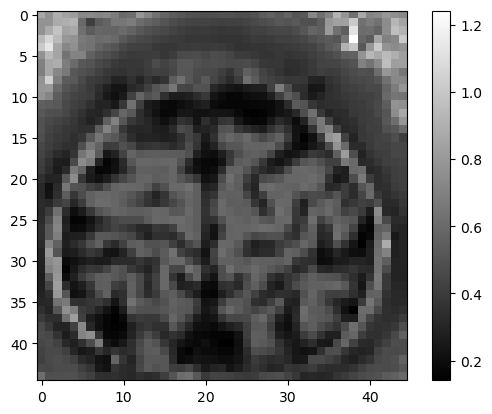

In [22]:
plt.imshow(np.fliplr(np.rot90(Sqs[25:70:, 25:70, 43, 0])), cmap = 'gray') 
plt.colorbar()
plt.show()

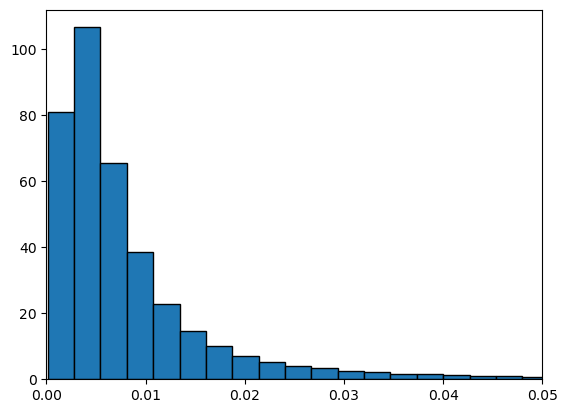

In [24]:
plt.hist(sigma[mask, :].ravel(), density = True, bins = 80000, edgecolor = 'black')
plt.xlim(0, 0.05)
plt.show()

In [224]:
np.savez('/Users/xunan/Projects/MaxEnt/Data/processed_numpy.npz', Sqs=Sqs, Sb0=Sb0, qs = qs, sigma=sigma)

# Compare

In [7]:
import torch
hpc = torch.load("/Users/xunan/Downloads/R_0_solution.pt", map_location="cpu")
print(type(hpc))
print(hpc.keys() if isinstance(hpc, dict) else hpc.shape)

<class 'dict'>
dict_keys(['std_vector', 'R', 'theta1', 'theta2', 'lin2idx', 'lambdas', 'f_hat', 'obj_history'])


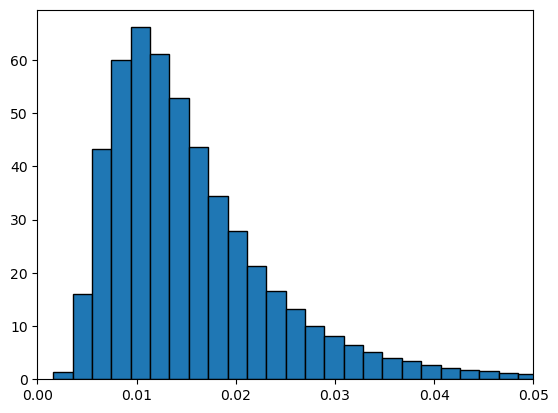

In [8]:
plt.hist(hpc['std_vector'], density = True, bins = 300, edgecolor = 'black')
plt.xlim(0, 0.05)
plt.show()

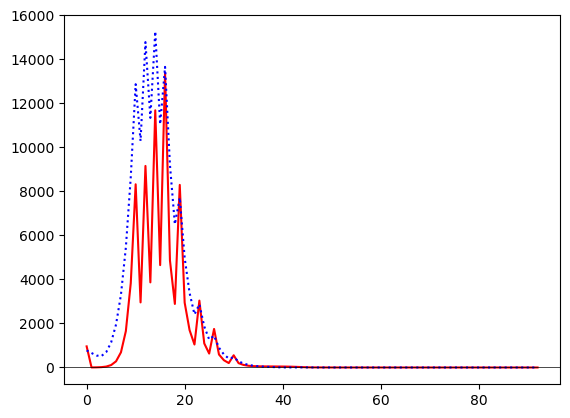

In [9]:
plt.plot(hpc['obj_history'][1][:], '-', color = 'red', label = 'primal')
plt.plot(hpc['obj_history'][2][:], ':', color = 'blue', label = 'dual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.show()

In [10]:
bf.contourf_mask(   hpc['theta1'], 
                    hpc['theta2'], 
                    hpc['f_hat'].numpy(), 
                    hpc['lin2idx'].numpy(), 
                    axis = 1, slice = 31)

In [ ]:
Sqs[:, torch.arange(Sqs.shape[1]) != i].shape

(663, 24)

In [ ]:
idx = hpc['lin2idx'].numpy().astype(np.intp)            # ensure integer index type
out = np.zeros(hpc['lin2idx'].numpy().shape, dtype=hpc['std_vector'].numpy().dtype)
mask = idx >= 0
out[mask] = hpc['std_vector'][idx[mask]]

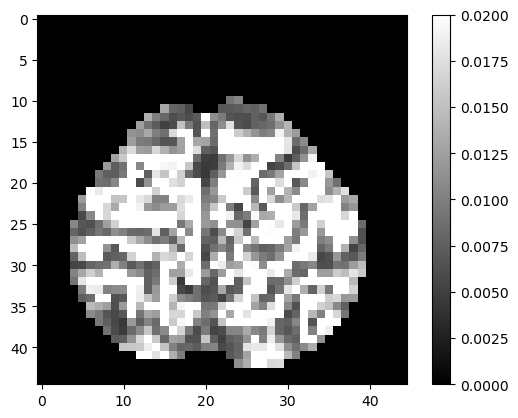

In [ ]:
plt.imshow(np.fliplr(np.rot90(out[25:70:, 25:70, 43])), vmin=0.0, vmax=0.02, cmap = 'gray')# , vmin = 0, vmax = 4029)
plt.colorbar()
plt.show()